In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [9]:
def parse_file(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    result = {}
    for line in lines:
        if 'CCSD(T) total energy' in line:
            result['ccsdpt'] = float(line.strip().split()[-1])
        
        if 'Nuclear repulsion energy [au]' in line:
            result['nn'] = float(line.strip().split()[-1])
            
    return result
def bond_count(label):
    bonds = {'BH': 0, 'CH': 0, 'HN': 0, 'BB': 0, 'BC': 0, 'BN': 0, 'CC': 0, 'CN': 0, 'NN': 0, }
    infile = [(0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 6), (2, 10), (3, 7), (3, 11), (4, 8), (4, 12), (5, 9), (5, 13), (6, 7), (6, 14), (7, 15), (8, 9), (8, 16), (9, 17)]
    raise ValueError("label remove center atoms no H")
    for letter in label:
        k = ''.join(sorted([letter, "H"]))
        bonds[k] += 1
    
    for a,b in infile:
        if a > 9 or b > 9:
            continue
        k = ''.join(sorted([label[_] for _ in (a, b)]))
        bonds[k] += 1
    return bonds
def build_df():
    
    ret = []
    for folder in glob.glob("naphtalene/validation/validation/*/"):
        label = folder.split('/')[-2]
        res = parse_file(folder + "run.log")
        res['label'] = label
        res['nBN'] = len([_ for _ in label if _ == "N"])
        ret.append(res)
    return pd.DataFrame(ret)
#explicit = build_df()

In [38]:
A = np.zeros((len(explicit), 9))
b = np.zeros(len(explicit))
bondorder = sorted(bond_count(explicit.label.values[0]).keys())
for idx, row in explicit.reset_index().iterrows():
    counts = bond_count(row.label)
    A[idx] = [counts[_] for _ in bondorder]
    b[idx] = row.ccsdpt

In [65]:
energies = np.linalg.lstsq(A, b)[0]

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


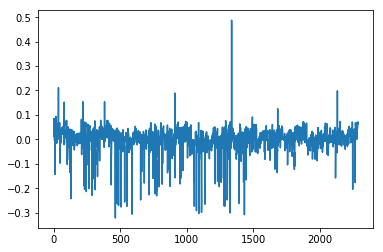

In [66]:
plt.plot(np.dot(A, energies)-b)

In [67]:
[_ for _ in zip(bondorder, list(np.round(energies, 5)))]

[('BB', -13.52059),
 ('BC', -13.57194),
 ('BH', -25.21689),
 ('BN', -13.6299),
 ('CC', -13.57588),
 ('CH', -23.54689),
 ('CN', -13.56846),
 ('HN', -25.21689),
 ('NN', -13.51198)]

In [57]:
bondorder

['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']

In [74]:
def parse_ranked(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    order = []
    groups = []
    count = 0
    for line in lines:
        if "Found:" in line:
            label = ''.join(line.split('[')[1].split(']')[0].replace(' ', '').split(','))
            label = label.replace('5', 'B').replace('6', 'C').replace('7', 'N')
            order.append(label)
            count += 1
        
        if "Group energy" in line:
            groups.append(count)
            count = 0
    return order, groups[1:]
def bond_count(label):
    bonds = {'BH': 0, 'CH': 0, 'HN': 0, 'BB': 0, 'BC': 0, 'BN': 0, 'CC': 0, 'CN': 0, 'NN': 0, }
    infile = [(4, 14), (3, 13), (3, 9), (2, 3), (4, 9), (4, 5), (5, 15), (2, 12), (8, 9), (1, 2), (5, 6), (1, 11), (0, 1), (6, 16), (6, 7), (7, 8), (0, 8), (7, 17), (0, 10)]
    for letter in label[:-2]:
        k = ''.join(sorted([letter, "H"]))
        bonds[k] += 1
    
    for a,b in infile:
        if a > 9 or b > 9:
            continue
        k = ''.join(sorted([label[_] for _ in (a, b)]))
        bonds[k] += 1
    return bonds

In [70]:
ranked, groups = parse_ranked('napthalene-molpro.report')

In [101]:
def ac_bond(start, stop):
    A = np.zeros((stop-start, 9))
    b = np.zeros(stop-start)
    bondorder = sorted(bond_count(ranked[0]).keys())
    for idx, row in enumerate(ranked[start:stop]):
        counts = bond_count(row)
        A[idx] = [counts[_] for _ in bondorder]
        b[idx] = 100
    return np.linalg.lstsq(A, b)

In [102]:
ac_bond(1407, 1897)

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


(array([3.72526193, 4.88940629, 5.23864959, 3.37601863, 6.05355064,
        6.40279395, 4.54016298, 6.98486612, 3.02677532]),
 array([], dtype=float64),
 5,
 array([1.52228713e+02, 3.14868370e+01, 2.87067146e+01, 2.26015170e+01,
        2.15892095e+01, 1.23367432e-14, 8.15322544e-15, 4.46695453e-15,
        2.20638416e-15]))

In [97]:
np.cumsum(groups)

array([   1,   39,   53,   65,   66,   68,   69,  741,  762,  873,  876,
       1372, 1407, 1897, 1932, 1940, 2002, 2016, 2210, 2252, 2258, 2262,
       2263, 2265, 2267, 2270, 2274, 2276, 2283, 2285])

In [104]:
ac_bond(876, 1372)

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


(array([ -2.57130968,  -1.20556002,  20.89330239,  -0.49849818,
          0.16018964,  22.25905205,   0.86725148, -13.98704215,
          1.57431333]),
 array([], dtype=float64),
 6,
 array([1.54987309e+02, 3.33705552e+01, 2.98592153e+01, 2.33922588e+01,
        1.56387224e+01, 2.75454374e-14, 1.04884049e-14, 4.71460436e-15,
        2.62126021e-15]))

In [106]:
bondorder

['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']